In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from market import IntegratedMarketModel

In [2]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
n_firms = 10 
n_consumers = 10000
n_chars = 2
T = 100
# approximately the model at true parameters and at the estimation value of the parameters 


# values from sigma and mu retrived from the wolfram calculator
sigma_hat = 0.19
# sigma_hat = 0.2
mu_hat = 0.51
# mu_hat = 0.5
beta1_hat = 1.990256
beta2_hat = -0.301219
beta3_hat = -0.301233


# for the production function estimation 
# theta_l_hat = .6000834 
# From the ACF method
theta_l_hat = .6011422
wage_hat = 15

print(mu_hat)

0.51


In [4]:
# Instead of this it can also be posibile to just plug in the model estimation from seed 100 directly from 
# the created datasets
seed = 4
df= pd.read_csv(f'../data/market_integrates_{seed}.csv')
print(df)


model_true = IntegratedMarketModel(
        n_firms, 
        n_consumers, 
        n_chars, 
        T, 
        seed=seed
    )
model_true.demand_side_optimisation()


     market_ids  firm_ids  characteristic1  characteristic2    prices  \
0             1         1         4.582194         1.697368  4.572060   
1             1         2         4.904177         3.831666  4.295544   
2             1         3         1.272172         3.596674  4.809153   
3             1         4         4.533492         1.943444  4.598940   
4             1         5         3.396054         4.213493  4.469387   
..          ...       ...              ...              ...       ...   
995         100         6         1.712343         4.454706  4.589379   
996         100         7         3.032257         5.808905  4.213014   
997         100         8         5.301537         5.261936  3.829661   
998         100         9         4.131692         5.935763  4.236585   
999         100        10         2.749951         5.557247  4.592509   

     marginal_cost    shares   profits   markups  e_quantity    capital  \
0         3.793774  0.001272  0.000990  1.205148

In [5]:
model_estimated = IntegratedMarketModel(
        n_firms, 
        n_consumers, 
        n_chars, 
        T, 
        seed=seed,
        beta1=beta1_hat, 
        beta2=beta2_hat,
        beta3=beta3_hat,
        mu=mu_hat,
        sigma=sigma_hat,
    )


vp_estimates = np.random.normal(0, 1, (n_consumers, T))
e=0


# print(probabilities_purchase)

In [6]:
estimated_markups = np.zeros((n_firms, T))

for t in range(T):
    market_shares, probabilities_purchase, _ = model_estimated.compute_share(vp_estimates[:,t], model_true.prices[:,t], e)
    approximated_Jacobian = model_estimated.construct_Jacobian(probabilities_purchase, vp_estimates[:,t])

    inverse_Jacobian = np.linalg.inv(approximated_Jacobian)
    estimated_marginal_costs_period0 = np.matmul(inverse_Jacobian, model_true.market_shares[:,t]) + model_true.prices[:,t]

    estimated_markups_period0 = model_true.prices[:,t] / estimated_marginal_costs_period0 
    estimated_markups[:,t] = estimated_markups_period0

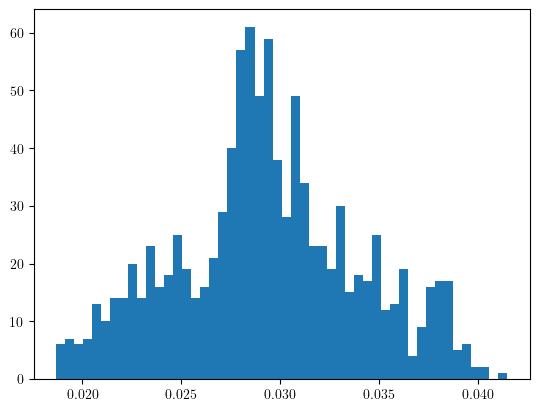

In [7]:
plt.hist(np.abs(estimated_markups.flatten() - model_true.markups.flatten()), bins=50)
plt.show()

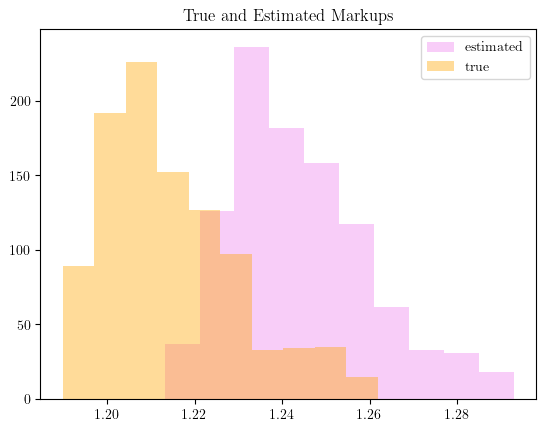

In [8]:
# The approximation of the market equilibirum and the Jacobian needs to be separately determined 
plt.hist(estimated_markups.flatten(), 
         bins=10,
         alpha=0.4, 
         label='estimated',
         color='violet') # customized color parameter
  
plt.hist(model_true.markups.flatten(),
         bins=10, 
         alpha=0.4,
         label='true',
         color='orange')

plt.title('True and Estimated Markups')
plt.legend(loc='upper right')
plt.show()





In [9]:
# e = 0 

# vp_true = model_true.v_p[:,0]
# vp_other_draw = model_estimated.v_p[:,0]

# true_prices_period_0 = model_true.prices[:,0]
# true_market_shares, true_probs, _ = model_true.compute_share(vp_true, true_prices_period_0, e)
# estim_market_shares, estim_probs, _ = model_estimated.compute_share(vp_other_draw, true_prices_period_0, e)


# J_true = model_true.construct_Jacobian(true_probs, vp_true)
# J_approx = model_estimated.construct_Jacobian(estim_probs, vp_other_draw)


# J_true_flat = J_true.flatten()
# J_approx_flat = J_approx.flatten()


# # Compare the matrices element-wise with a tolerance of 0.2
# comparison = np.allclose(J_true, J_approx, atol=1e-03)

# # Print the result
# if comparison:
#     print("The matrices are approximately the same.")
# else:
#     print("The matrices are different.")


In [10]:
# plt.hist(J_true_flat, 
#          bins=10,
#          alpha=0.4, 
#          label='true',
#          color='violet') # customized color parameter
  
# plt.hist(J_approx_flat,
#          bins=10, 
#          alpha=0.4,
#          label='approximated',
#          color='orange')

# plt.title('True and Approximated First Order Price Derivatives in the Jacobian')
# plt.legend(loc='upper right')
# plt.show()

In [11]:
a1, a2, a0, s0 = model_true.get_alphas()
print(a0)
print(s0)

hat_a1, hat_a2, hat_a0, hat_s0 = model_estimated.get_alphas()
print(hat_a0)
print(hat_s0)


a2_final = a2.flatten()
hat_a2_final = hat_a2.flatten()


-1.6820276496988864
0.33979778797685584
-1.6956226186132577
0.32509785264490526


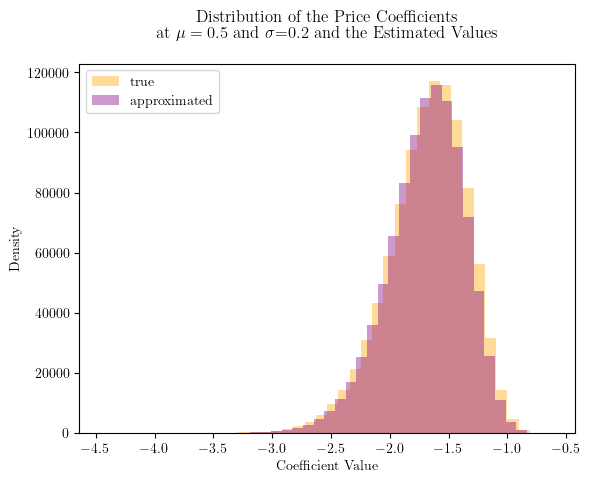

In [12]:
 
plt.hist(a2_final,
         bins=40, 
         alpha=0.4,
         label='true',
         color='orange')

plt.hist(hat_a2_final,
         bins=40, 
         alpha=0.4,
         label='approximated',
         color='purple')

plt.title('Distribution of the Price Coefficients \n at $\mu = 0.5$ and $\sigma$=0.2 and the Estimated Values\n')
plt.xlabel('Coefficient Value')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.savefig('../plots/distr_price_coeff.pdf')
plt.show()

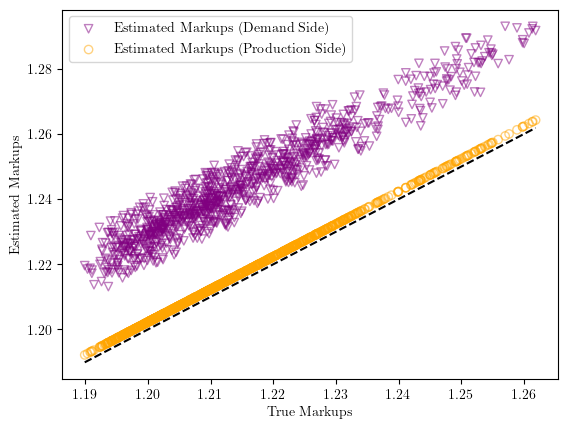

In [13]:
# For figure 1 I need the markups as the estimated parameter values and estimated shocks
true_markups = model_true.markups.flatten()
estimated_markups_demand_side = estimated_markups
# markups under the assumption of exact product price knowledge
estimated_markups_production_side = (theta_l_hat * model_true.prices.flatten()*
                                     model_true.market_shares.flatten()
                                     *n_consumers)/( wage_hat* model_true.labor_quantity.flatten())

# Create the scatter plot
plt.scatter(true_markups, estimated_markups_demand_side, 
            color='purple',
              label='Estimated Markups (Demand Side)', marker='v',
               alpha=0.5, facecolors='none', edgecolors='purple')
plt.scatter(true_markups, estimated_markups_production_side,
             color='orange',
               label='Estimated Markups (Production Side)', marker='o',
                alpha=0.5, facecolors='none', edgecolors='orange')

plt.plot([min(true_markups), max(true_markups)], [min(true_markups), max(true_markups)], color='black', linestyle='--')

# Set the labels and title
plt.xlabel('True Markups')
plt.ylabel('Estimated Markups')

# Add a legend
plt.legend()

# Display the plot
plt.show()




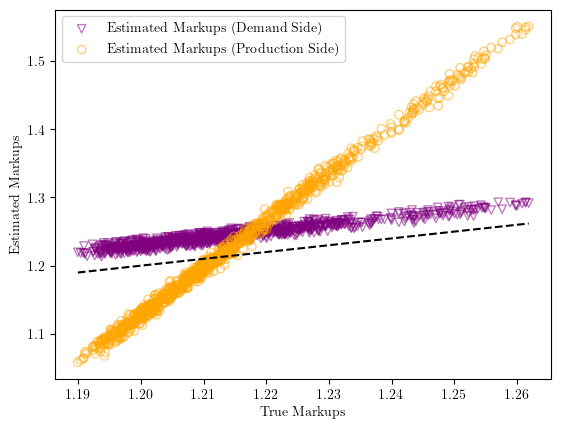

In [14]:
#  Figure 2 where we do not know the exact 
# markups under the assumption of average price level where we approximate a market price overall for 
# the firms as there is no price-level data (only using production data) 
# situation where researcher just has firm level revenue and not prices for the firm 

prices = np.zeros((n_firms*T)) + 4.4


estimated_markups_production_side = (theta_l_hat * prices *
                                     model_true.market_shares.flatten()
                                     *n_consumers)/( wage_hat* model_true.labor_quantity.flatten())

# Create the scatter plot
plt.scatter(true_markups, estimated_markups_demand_side, 
            color='purple',
              label='Estimated Markups (Demand Side)',  marker='v',
               alpha=0.5, facecolors='none', edgecolors='purple')
plt.scatter(true_markups, estimated_markups_production_side,
             color='orange',
               label='Estimated Markups (Production Side)', marker='o',
                alpha=0.5, facecolors='none', edgecolors='orange')
plt.plot([min(true_markups), max(true_markups)], [min(true_markups), max(true_markups)], color='black', linestyle='--')


# Set the labels and title
plt.xlabel('True Markups')
plt.ylabel('Estimated Markups')

# Add a legend
plt.legend()

# Display the plot

In [ ]:
#  Figure 3 where we do not know the exact 
# assume that there is either misspecification of the wage and the prices at the same time and 
# How the results differ in either of the directions


